# Pylops - Least squares migration (traveltime only)

### Author: M.Ravasi

In this notebook I will show you how to perform least-squares migration with a Kirchhoff modelling operator.

The modelling is simply expressed by the following equation

$$ d(s, r, t) = w(t) * \int_V G(x,s, t) G(r,x, t) r(x,z) dx dz$$

where $r(x, z)$ is our model and it represents the reflectivity at every location in the subsurface, $G(r,x, t)$ and $G(x,s, t)$ are the Green's functions from source to subsurface to receiver and finally $w$ is the wavelet.

In a matrix for

$$ \mathbf{d} = \mathbf{W} \mathbf{G} \mathbf{r}$$

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import skfmm

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy.signal import convolve, filtfilt

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.kirchhoff import Kirchhoff
from pylops.waveeqprocessing.lsm import LSM

from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *

## 2D layered in homogenous velocity

Lets' create a model and geometry

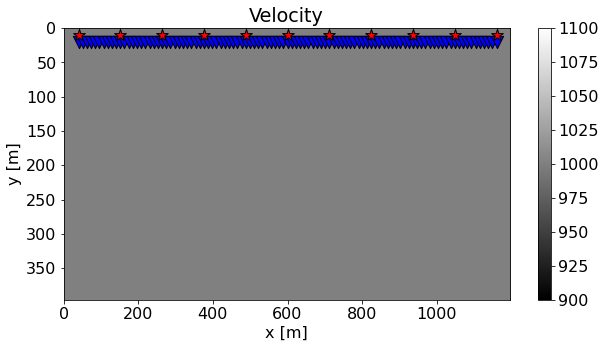

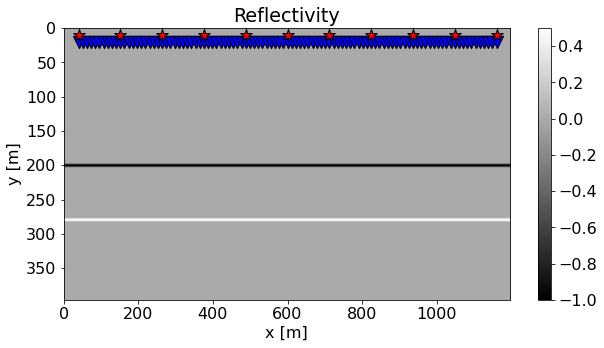

In [2]:
# Velocity Model
nx, nz = 300, 100
dx, dz = 4, 4
x, z = np.arange(nx)*dx, np.arange(nz)*dz
v0 = 1000 # initial velocity
kv = 0. # gradient
vel = np.outer(np.ones(nx), v0 +kv*z) 

# Reflectivity Model
refl = np.zeros((nx, nz))
#refl[:, 20] = 1
refl[:, 50] = -1
refl[:, 70] = 0.5

# Receivers
nr = 101
rx = np.linspace(10*dx, (nx-10)*dx, nr)
rz = 20*np.ones(nr)
recs = np.vstack((rx, rz))
dr = recs[0,1]-recs[0,0]

# Sources
ns = 11
sx = np.linspace(dx*10, (nx-10)*dx, ns)
sz = 10*np.ones(ns)
sources = np.vstack((sx, sz))
ds = sources[0,1]-sources[0,0]

plt.figure(figsize=(10,5))
im = plt.imshow(vel.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Velocity')
plt.xlim(x[0], x[-1])

plt.figure(figsize=(10,5))
im = plt.imshow(refl.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Reflectivity')
plt.xlim(x[0], x[-1]);

Compute traveltimes for homogenous medium

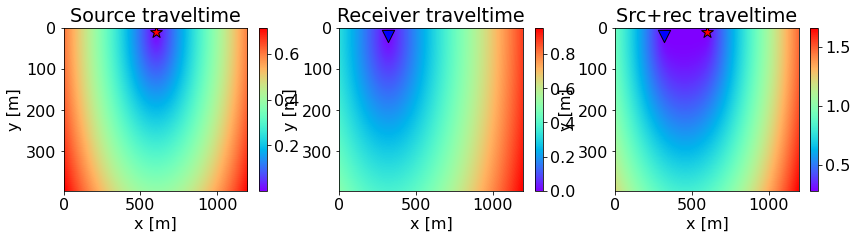

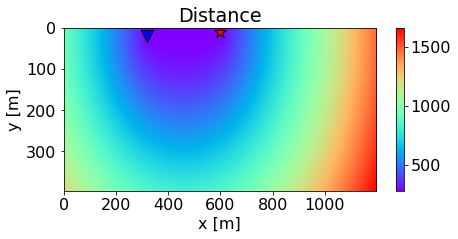

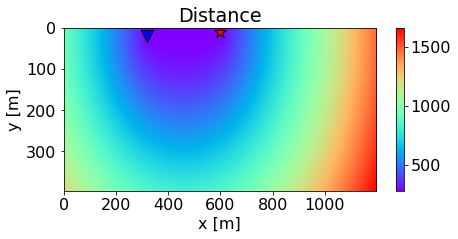

In [3]:
trav_srcs, trav_recs, dist_srcs, dist_recs, trav_srcs_grad, trav_recs_grad = \
    Kirchhoff._traveltime_table(z, x, sources, recs, v0, mode='analytic')

trav = trav_srcs.reshape(nx * nz, ns, 1) + trav_recs.reshape(nx * nz, 1, nr)
trav = trav.reshape(nx * nz, ns * nr)
dist = dist_srcs.reshape(nx * nz, ns, 1) + dist_recs.reshape(nx * nz, 1, nr)
dist = dist.reshape(nx * nz, ns * nr)


fig, axs = plt.subplots(1, 3, figsize=(14, 3))
im = axs[0].imshow(trav_srcs[:, ns//2].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[0].scatter(sources[0, ns//2], sources[1, ns//2], marker='*', s=150, c='r', edgecolors='k')
axs[0].axis('tight')
axs[0].set_xlabel('x [m]')
axs[0].set_ylabel('y [m]')
axs[0].set_title('Source traveltime')
axs[0].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(trav_recs[:, nr//4].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[1].scatter(recs[0, nr//4], recs[1, nr//4], marker='v', s=150, c='b', edgecolors='k')
axs[1].axis('tight')
axs[1].set_xlabel('x [m]')
axs[1].set_ylabel('y [m]')
axs[1].set_title('Receiver traveltime')
axs[1].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[1])
im = axs[2].imshow(trav[:, ns//2*nr+nr//4].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[2].scatter(sources[0, ns//2], sources[1, ns//2], marker='*', s=150, c='r', edgecolors='k')
axs[2].scatter(recs[0, nr//4], recs[1, nr//4], marker='v', s=150, c='b', edgecolors='k')
axs[2].axis('tight')
axs[2].set_xlabel('x [m]')
axs[2].set_ylabel('y [m]')
axs[2].set_title('Src+rec traveltime')
axs[2].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[2]);

fig, ax = plt.subplots(1, 1, figsize=(7, 3))
im = ax.imshow(dist[:, ns//2*nr+nr//4].reshape((nx, nz)).T, cmap='rainbow', 
               extent = (x[0], x[-1], z[-1], z[0]))
ax.scatter(sources[0, ns//2], sources[1, ns//2], marker='*', s=150, c='r', edgecolors='k')
ax.scatter(recs[0, nr//4], recs[1, nr//4], marker='v', s=150, c='b', edgecolors='k')
ax.axis('tight')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('Distance')
ax.set_ylim(z[-1], z[0])
plt.colorbar(im, ax=ax)

fig, ax = plt.subplots(1, 1, figsize=(7, 3))
im = ax.imshow(dist[:, ns//2*nr+nr//4].reshape((nx, nz)).T, cmap='rainbow', 
               extent = (x[0], x[-1], z[-1], z[0]))
ax.scatter(sources[0, ns//2], sources[1, ns//2], marker='*', s=150, c='r', edgecolors='k')
ax.scatter(recs[0, nr//4], recs[1, nr//4], marker='v', s=150, c='b', edgecolors='k')
ax.axis('tight')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('Distance')
ax.set_ylim(z[-1], z[0])
plt.colorbar(im, ax=ax);

Let's do the same using an eikonal solver

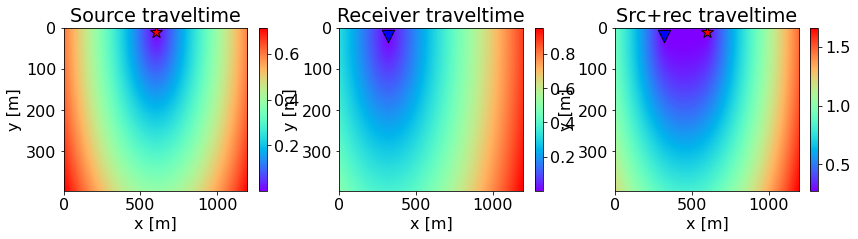

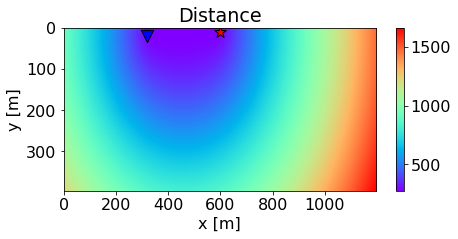

In [4]:
trav_srcs_eik, trav_recs_eik, dist_srcs_eik, dist_recs_eik, _, _ = \
    Kirchhoff._traveltime_table(z, x, sources, recs, vel, mode='eikonal')

trav_eik = trav_srcs_eik.reshape(nx * nz, ns, 1) + trav_recs_eik.reshape(nx * nz, 1, nr)
trav_eik = trav_eik.reshape(nx * nz, ns * nr)
dist_eik = dist_srcs_eik.reshape(nx * nz, ns, 1) + dist_recs_eik.reshape(nx * nz, 1, nr)
dist_eik = dist_eik.reshape(nx * nz, ns * nr)


fig, axs = plt.subplots(1, 3, figsize=(14, 3))
im = axs[0].imshow(trav_srcs_eik[:, ns//2].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[0].scatter(sources[0, ns//2], sources[1, ns//2], marker='*', s=150, c='r', edgecolors='k')
axs[0].axis('tight')
axs[0].set_xlabel('x [m]')
axs[0].set_ylabel('y [m]')
axs[0].set_title('Source traveltime')
axs[0].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(trav_recs_eik[:, nr//4].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[1].scatter(recs[0, nr//4], recs[1, nr//4], marker='v', s=150, c='b', edgecolors='k')
axs[1].axis('tight')
axs[1].set_xlabel('x [m]')
axs[1].set_ylabel('y [m]')
axs[1].set_title('Receiver traveltime')
axs[1].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[1])
im = axs[2].imshow(trav_eik[:, ns//2*nr+nr//4].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[2].scatter(sources[0, ns//2], sources[1, ns//2], marker='*', s=150, c='r', edgecolors='k')
axs[2].scatter(recs[0, nr//4], recs[1, nr//4], marker='v', s=150, c='b', edgecolors='k')
axs[2].axis('tight')
axs[2].set_xlabel('x [m]')
axs[2].set_ylabel('y [m]')
axs[2].set_title('Src+rec traveltime')
axs[2].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[2])

fig, ax = plt.subplots(1, 1, figsize=(7, 3))
im = ax.imshow(dist_eik[:, ns//2*nr+nr//4].reshape((nx, nz)).T, cmap='rainbow', 
               extent = (x[0], x[-1], z[-1], z[0]))
ax.scatter(sources[0, ns//2], sources[1, ns//2], marker='*', s=150, c='r', edgecolors='k')
ax.scatter(recs[0, nr//4], recs[1, nr//4], marker='v', s=150, c='b', edgecolors='k')
ax.axis('tight')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('Distance')
ax.set_ylim(z[-1], z[0])
plt.colorbar(im, ax=ax);

Finally we model the data and invert it

In [5]:
nt = 651
dt = 0.004
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:41], f0=20)

itrav = (np.floor(trav/dt)).astype(np.int32)
travd = (trav/dt - itrav)
itrav = itrav.reshape(nx, nz, ns*nr)
travd = travd.reshape(nx, nz, ns*nr)

In [6]:
lsm = LSM(z, x, t, sources, recs, v0, wav, wavc, mode='analytic', engine='numba')
dottest(lsm.Demop, verb=True)

d = lsm.Demop * refl.ravel()
d = d.reshape(ns, nr, nt)

madj = lsm.Demop.H * d.ravel()
madj = madj.reshape(nx, nz)

minv = lsm.solve(d.ravel(), solver=lsqr, **dict(iter_lim=100, show=True))
minv = minv.reshape(nx, nz)

minv_sparse = lsm.solve(d.ravel(), solver=fista, **dict(eps=1e3, niter=200, show=True))
minv_sparse = minv_sparse.reshape(nx, nz)

minv_sgpl1 = lsm.solve(d.ravel(), solver=spgl1, **dict(sigma=1e-4, iter_lim=100, verbosity=2))
minv_sgpl1 = minv_sgpl1.reshape(nx, nz)

# demigration
dadj = lsm.Demop * madj.ravel()
dadj = dadj.reshape(ns, nr, nt)

dinv = lsm.Demop * minv.ravel()
dinv = dinv.reshape(ns, nr, nt)

dinv_sparse = lsm.Demop * minv_sparse.ravel()
dinv_sparse = dinv_sparse.reshape(ns, nr, nt)

dinv_sgpl1 = lsm.Demop * minv_sgpl1.ravel()
dinv_sgpl1 = dinv_sgpl1.reshape(ns, nr, nt)

Dot test passed, v^H(Opu)=-14384.78368610033 - u^H(Op^Hv)=-14384.783686100312
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 723261 rows and 30000 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =      100
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.723e+03  2.723e+03    1.0e+00  1.7e-01
     1 -6.02452e-03   1.756e+03  1.756e+03    6.4e-01  6.4e-01   6.1e+02  1.0e+00
     2 -6.13417e-03   1.592e+03  1.592e+03    5.8e-01  5.0e-01   1.2e+03  2.4e+00
     3 -5.75441e-03   1.277e+03  1.277e+03    4.7e-01  1.5e-01   2.0e+03  5.4e+00
     4 -4.30109e-03   1.022e+03  1.022e+03    3.8e-01  1.3e-01   2.1e+03  7.7e+00
     5 -3.07184e-03   8.504e+02  8.504e+02    3.1e-01  1.1e-01   2.2e+03  1.0e+01
     6 -1.13252e-03   7.840e+02  7.840e+02    2.9e-01  1.4e-01   2.3e+03  1.2e+01
     7  2.25267e-03   6.756e+02  6.

   94  1.7700086e+02  1.6506568e+01   1.00e+00  7.335e+02    -0.6    3371       0               
   95  1.7775123e+02  1.4840468e+01   1.00e+00  1.001e+03     0.0    3728       1               
   96  1.7248619e+02  1.0063543e+01   1.00e+00  6.002e+02     0.0    3214       1               
   97  1.7135662e+02  9.4073000e+00   1.00e+00  5.982e+02     0.0    3038       1               
   98  1.7065373e+02  9.1978048e+00   1.00e+00  5.959e+02     0.0    2988       1               
   99  1.6401877e+02  9.7524962e+00   1.00e+00  5.714e+02     0.0    2580       1               
  100  1.6732766e+02  2.3574893e+01   1.00e+00  1.186e+03    -0.6    2294       1               

ERROR EXIT -- Too many iterations

Products with A     :     138        Total time   (secs) :    20.1
Products with A^H   :     101        Project time (secs) :     0.4
Newton iterations   :       3        Mat-vec time (secs) :    18.2
Line search its     :      37        Subspace iterations :       0


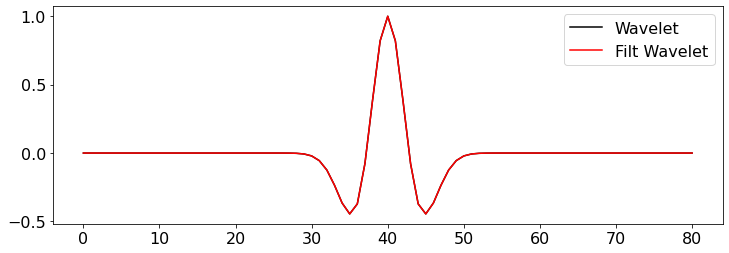

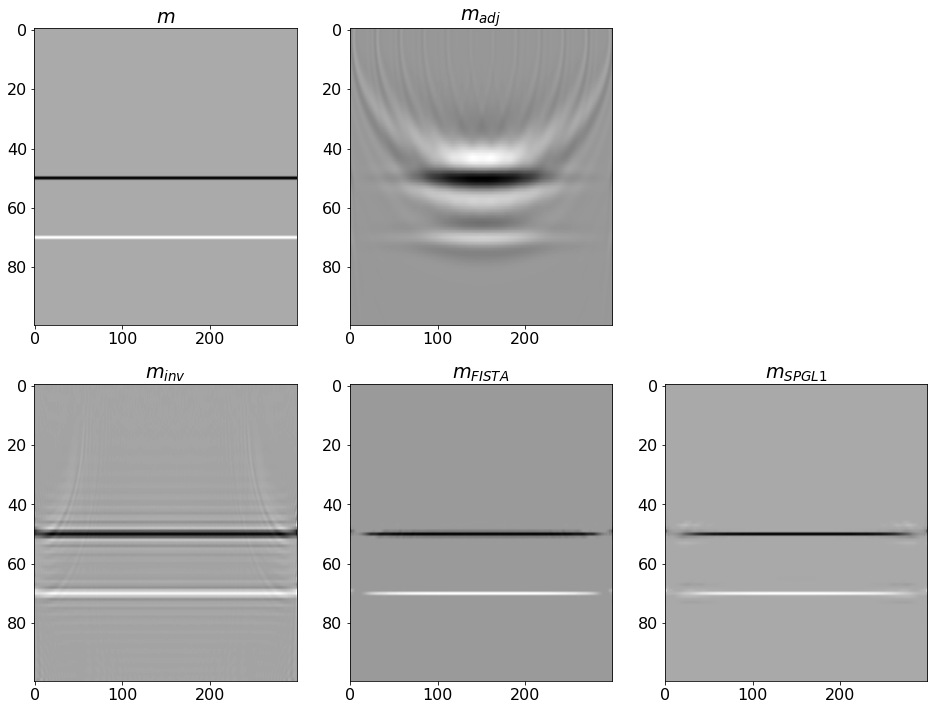

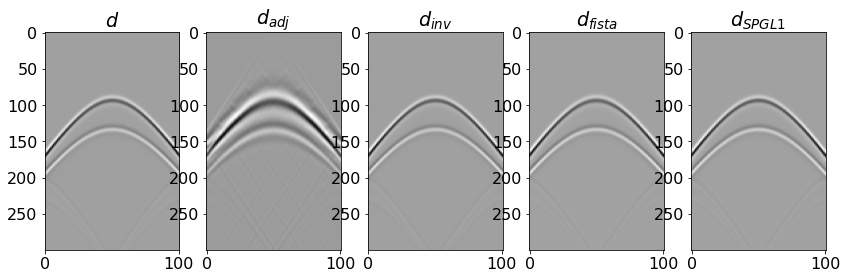

In [7]:
plt.figure(figsize=(12, 4))
plt.plot(wav / wav.max(), 'k', label='Wavelet')
plt.plot(lsm.Demop.wav / lsm.Demop.wav.max(), 'r', label='Filt Wavelet')
plt.legend()

fig, axs = plt.subplots(2, 3, figsize=(16, 12))
axs[0][0].imshow(refl.T, cmap='gray')
axs[0][0].axis('tight')
axs[0][0].set_title(r'$m$')
axs[0][1].imshow(madj.T, cmap='gray')
axs[0][1].set_title(r'$m_{adj}$')
axs[0][1].axis('tight')
axs[0][2].axis('off')
axs[1][0].imshow(minv.T, cmap='gray')
axs[1][0].axis('tight')
axs[1][0].set_title(r'$m_{inv}$');
axs[1][1].imshow(minv_sparse.T, cmap='gray')
axs[1][1].axis('tight')
axs[1][1].set_title(r'$m_{FISTA}$');
axs[1][2].imshow(minv_sgpl1.T, cmap='gray')
axs[1][2].axis('tight')
axs[1][2].set_title(r'$m_{SPGL1}$');

fig, axs = plt.subplots(1, 5, figsize=(14, 4))
axs[0].imshow(d[ns//2, :, :300].T, cmap='gray')
axs[0].set_title(r'$d$')
axs[0].axis('tight')
axs[1].imshow(dadj[ns//2, :, :300].T, cmap='gray')
axs[1].set_title(r'$d_{adj}$')
axs[1].axis('tight')
axs[2].imshow(dinv[ns//2, :, :300].T, cmap='gray')
axs[2].set_title(r'$d_{inv}$')
axs[2].axis('tight')
axs[3].imshow(dinv_sparse[ns//2, :, :300].T, cmap='gray')
axs[3].set_title(r'$d_{fista}$')
axs[3].axis('tight');
axs[4].imshow(dinv_sgpl1[ns//2, :, :300].T, cmap='gray')
axs[4].set_title(r'$d_{SPGL1}$')
axs[4].axis('tight');

## 2D layered in gradient velocity

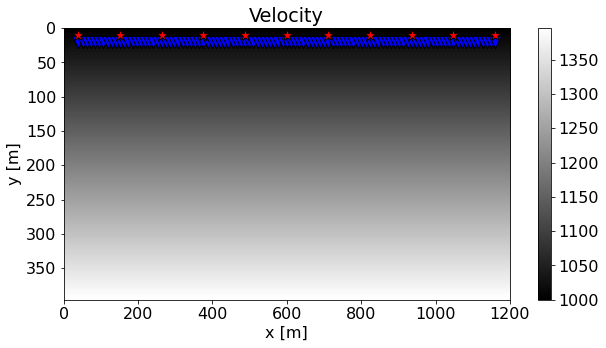

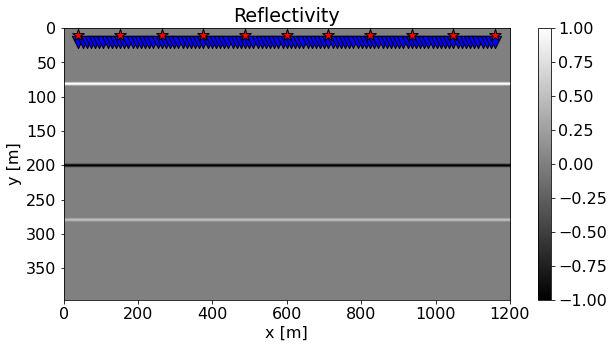

In [8]:
# Velocity Model
nx, nz = 301, 100
dx, dz = 4, 4
x, z = np.arange(nx)*dx, np.arange(nz)*dz
v0 = 1000 # initial velocity
kv = 1 # gradient
vel = np.outer(np.ones(nx), v0 +kv*z) 

# Reflectivity Model
refl = np.zeros((nx, nz))
refl[:, 20] = 1
refl[:, 50] = -1
refl[:, 70] = 0.5

plt.figure(figsize=(10,5))
im = plt.imshow(vel.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Velocity')
plt.xlim(x[0], x[-1])

plt.figure(figsize=(10,5))
im = plt.imshow(refl.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Reflectivity')
plt.xlim(x[0], x[-1]);

Compute traveltimes with eikonal

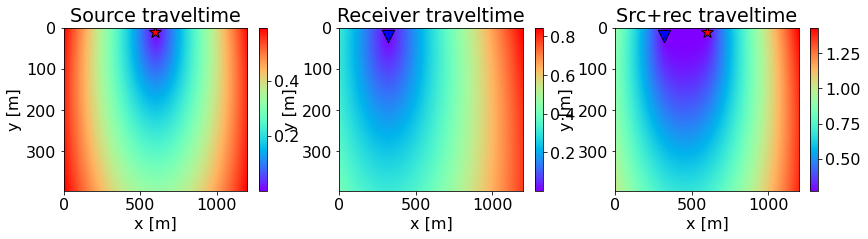

In [9]:
X, Z = np.meshgrid(x, z, indexing='ij')
X, Z = X.flatten(), Z.flatten()

trav_srcs, trav_recs, dist_srcs, dist_recs, trav_srcs_grad, trav_recs_grad = \
    Kirchhoff._traveltime_table(z, x, sources, recs, vel, mode='eikonal')

trav = trav_srcs.reshape(nx * nz, ns, 1) + trav_recs.reshape(nx * nz, 1, nr)
trav = trav.reshape(nx * nz, ns * nr)
dist = dist_srcs.reshape(nx * nz, ns, 1) + dist_recs.reshape(nx * nz, 1, nr)
dist = dist.reshape(nx * nz, ns * nr)


fig, axs = plt.subplots(1, 3, figsize=(14, 3))
im = axs[0].imshow(trav_srcs[:, ns//2].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[0].scatter(sources[0, ns//2], sources[1, ns//2], marker='*', s=150, c='r', edgecolors='k')
axs[0].axis('tight')
axs[0].set_xlabel('x [m]')
axs[0].set_ylabel('y [m]')
axs[0].set_title('Source traveltime')
axs[0].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(trav_recs[:, nr//4].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[1].scatter(recs[0, nr//4], recs[1, nr//4], marker='v', s=150, c='b', edgecolors='k')
axs[1].axis('tight')
axs[1].set_xlabel('x [m]')
axs[1].set_ylabel('y [m]')
axs[1].set_title('Receiver traveltime')
axs[1].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[1])
im = axs[2].imshow(trav[:, ns//2*nr+nr//4].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[2].scatter(sources[0, ns//2], sources[1, ns//2], marker='*', s=150, c='r', edgecolors='k')
axs[2].scatter(recs[0, nr//4], recs[1, nr//4], marker='v', s=150, c='b', edgecolors='k')
axs[2].axis('tight')
axs[2].set_xlabel('x [m]')
axs[2].set_ylabel('y [m]')
axs[2].set_title('Src+rec traveltime')
axs[2].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[2]);

Create data and invert model

In [10]:
nt = 601
dt = 0.004
t = np.arange(nt)*dt

itrav = (np.floor(trav/dt)).astype(np.int32)
travd = (trav/dt - itrav)
itrav = itrav.reshape(nx, nz, ns*nr)
travd = travd.reshape(nx, nz, ns*nr)

Sop = Spread(dims=(nx, nz), dimsd=(ns*nr, nt), table=itrav, dtable=travd, engine='numba')
wav, wavt, wavc = ricker(t[:41], f0=20)
Cop = Convolve1D(dims=(ns*nr, nt), h=wav, offset=wavc, axis=1)

LSMop = Cop*Sop
%timeit -n 3 -r 1 LSMop * refl.ravel()
d1 = LSMop * refl.ravel()

lsm = LSM(z, x, t, sources, recs, vel, wav, wavc, mode='eikonal', engine='numba')
%timeit -n 3 -r 1 LSMop * refl.ravel()

d = lsm.Demop * refl.ravel()
print(np.allclose(d, d1))
d = d.reshape(ns, nr, nt)

madj = lsm.Demop.H * d.ravel()
madj = madj.reshape(nx, nz)

minv = lsm.solve(d.ravel(), solver=lsqr, **dict(iter_lim=50, show=2))
minv = minv.reshape(nx, nz)

minv_sparse = lsm.solve(d.ravel(), solver=fista, **dict(eps=1e3, niter=200, show=True))
minv_sparse = minv_sparse.reshape(nx, nz)

# demigration
dadj = LSMop * madj.ravel()
dadj = dadj.reshape(ns, nr, nt)

dinv = LSMop * minv.ravel()
dinv = dinv.reshape(ns, nr, nt)

dinv_sparse = LSMop * minv_sparse.ravel()
dinv_sparse = dinv_sparse.reshape(ns, nr, nt)

371 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)
465 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)
True
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 667711 rows and 30100 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       50
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   6.389e+03  6.389e+03    1.0e+00  2.3e-01
     1 -6.21761e-05   3.477e+03  3.477e+03    5.4e-01  4.2e-01   1.7e+03  1.0e+00
     2 -4.08031e-04   2.467e+03  2.467e+03    3.9e-01  2.3e-01   2.1e+03  2.4e+00
     3 -5.28462e-04   1.963e+03  1.963e+03    3.1e-01  1.7e-01   2.3e+03  4.1e+00
     4 -8.03279e-04   1.439e+03  1.439e+03    2.3e-01  1.3e-01   2.4e+03  6.8e+00
     5 -1.16958e-03   1.225e+03  1.225e+03    1.9e-01  1.1e-01   2.5e+03  8.8e+00
     6 -2.51025e-03   1.019e+03  1.019e+03    1.6e-01  9.5e-

(-0.5, 100.5, 299.5, -0.5)

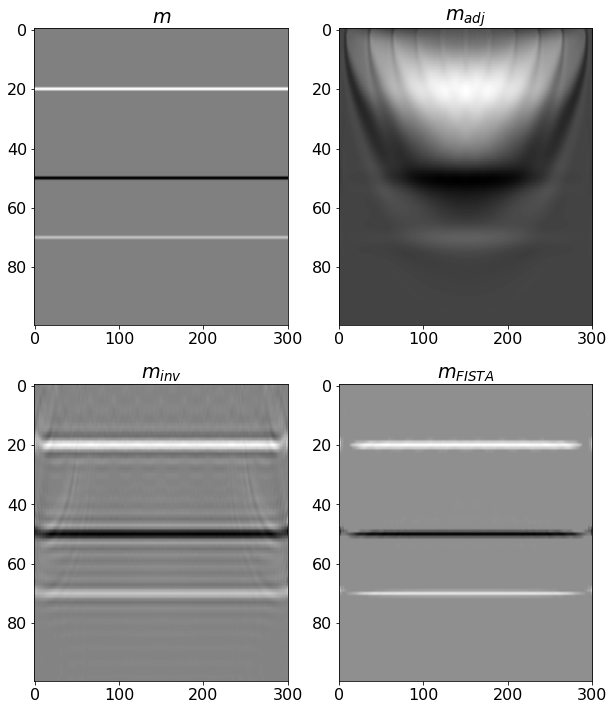

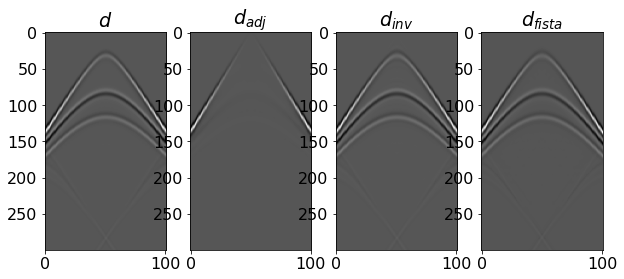

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(10, 12))
axs[0][0].imshow(refl.T, cmap='gray')
axs[0][0].axis('tight')
axs[0][0].set_title(r'$m$')
axs[0][1].imshow(madj.T, cmap='gray')
axs[0][1].set_title(r'$m_{adj}$')
axs[0][1].axis('tight')
axs[1][0].imshow(minv.T, cmap='gray')
axs[1][0].axis('tight')
axs[1][0].set_title(r'$m_{inv}$');
axs[1][1].imshow(minv_sparse.T, cmap='gray')
axs[1][1].axis('tight')
axs[1][1].set_title(r'$m_{FISTA}$');

fig, axs = plt.subplots(1, 4, figsize=(10, 4))
axs[0].imshow(d[ns//2, :, :300].T, cmap='gray')
axs[0].set_title(r'$d$')
axs[0].axis('tight')
axs[1].imshow(dadj[ns//2, :, :300].T, cmap='gray')
axs[1].set_title(r'$d_{adj}$')
axs[1].axis('tight')
axs[2].imshow(dinv[ns//2, :, :300].T, cmap='gray')
axs[2].set_title(r'$d_{inv}$')
axs[2].axis('tight')
axs[3].imshow(dinv_sparse[ns//2, :, :300].T, cmap='gray')
axs[3].set_title(r'$d_{fista}$')
axs[3].axis('tight')

Finally we try to invert for the velocity model itself

$$ \mathbf{d} = \mathbf{W} \mathbf{G}  \mathbf{D} \mathbf{m}$$

In [12]:
# Velocity Model
v0 = 1600 # initial velocity
vel = v0*np.ones((nx,nz))
vel[:, 40:50] = 1800
vel[:, 50:80] = 2000
vel[:, 80:] = 2500

# Smooth velocity
nsmooth=20
velback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, vel, axis=0)
for _ in range(5):
    velback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, velback, axis=1)

# Traveltime
nt = 401
dt = 0.004
t = np.arange(nt)*dt

trav_srcs, trav_recs, dist_srcs, dist_recs, trav_srcs_grad, trav_recs_grad = \
    Kirchhoff._traveltime_table(z, x, sources, recs, vel, mode='eikonal')

trav = trav_srcs.reshape(nx * nz, ns, 1) + trav_recs.reshape(nx * nz, 1, nr)
trav = trav.reshape(nx * nz, ns * nr)

itrav = (np.floor(trav/dt)).astype(np.int32)
travd = (trav/dt - itrav)
itrav = itrav.reshape(nx, nz, ns*nr)
travd = travd.reshape(nx, nz, ns*nr)

# Modelling
Sop = Spread(dims=(nx, nz), dimsd=(ns*nr, nt), table=itrav, dtable=travd, engine='numba')
dottest(Sop, ns*nr*nt, nx*nz, verb=True)

wav, wavt, wavc = ricker(t[:41], f0=20)
Cop = Convolve1D(dims=(ns*nr, nt), h=wav, offset=wavc, axis=1)
Dop = FirstDerivative(dims=(nx, nz), axis=1)
LSMop = Cop*Sop*Dop

d = LSMop * np.log(vel).ravel()
d = d.reshape(ns, nr, nt)
dback = LSMop * np.log(velback).ravel()
dback = dback.reshape(ns, nr, nt)

madj = (Cop*Sop).H * d.ravel()
madj = madj.reshape(nx, nz)

# Regularized inversion
Regop = SecondDerivative(dims=(nx, nz), axis=0)
minv = regularized_inversion(LSMop, d.ravel(), [Regop],
                             x0=np.log(velback).ravel(),
                             epsRs=[1e2], **dict(iter_lim=200, show=True))[0]
minv = np.exp(minv.reshape((nx, nz)))

# demigration
dadj = LSMop * madj.ravel()
dadj = dadj.reshape(ns, nr, nt)

dinv = LSMop * minv.ravel()
dinv = dinv.reshape(ns, nr, nt)

Dot test passed, v^H(Opu)=-7274.745206096426 - u^H(Op^Hv)=-7274.745206096412
RegularizedInversion
-----------------------------------------------------------------
The Operator Op has 445511 rows and 30100 cols
Regs=[<30100x30100 SecondDerivative with dtype=float64>]
epsRs=[100.0]
-----------------------------------------------------------------
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 475611 rows and 30100 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =      200
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   7.806e+02  7.806e+02    1.0e+00  1.9e-01
     1 -2.27866e-03   4.068e+02  4.068e+02    5.2e-01  1.0e+00   1.7e+02  1.0e+00
     2 -2.88678e-03   3.131e+02  3.131e+02    4.0e-01  4.7e-01   3.4e+02  2.4e+00
     3 -1.70365e-03   2.073e+02  2.073e+02    2.7e-01  2.1e-01   4.4e+02  4.2e+00
     4  3.7

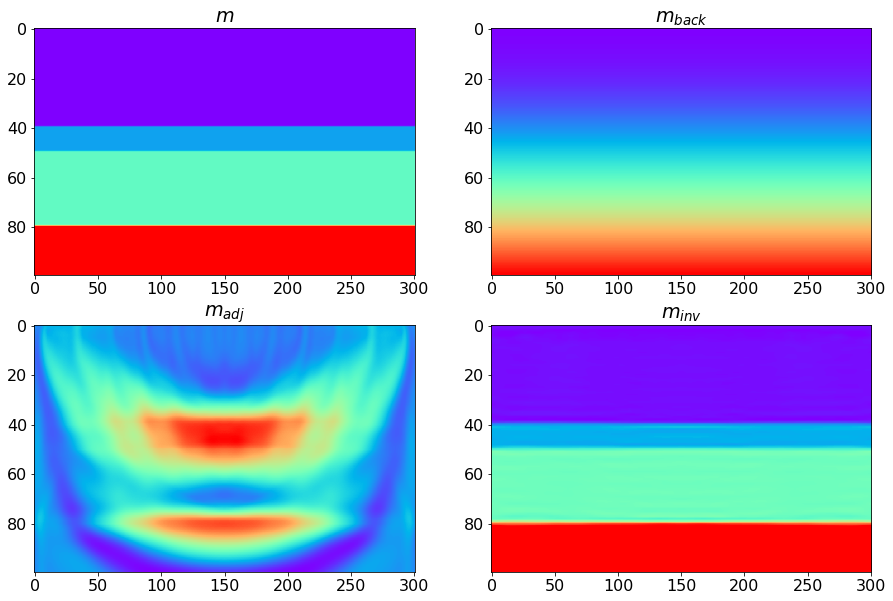

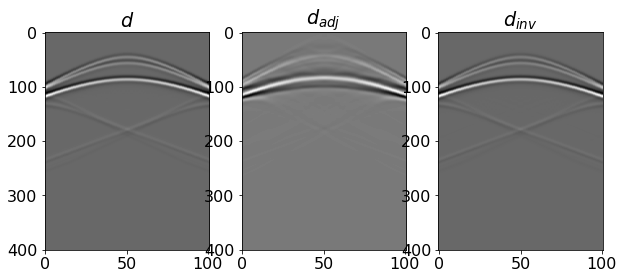

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0][0].imshow(vel.T, cmap='rainbow', vmin=v0, vmax=vel.max())
axs[0][0].axis('tight')
axs[0][0].set_title(r'$m$')
axs[0][1].imshow(velback.T, cmap='rainbow', vmin=v0, vmax=vel.max())
axs[0][1].set_title(r'$m_{back}$')
axs[0][1].axis('tight')
axs[1][0].imshow(madj.T, cmap='rainbow')
axs[1][0].axis('tight')
axs[1][0].set_title(r'$m_{adj}$');
axs[1][1].imshow(minv.T, cmap='rainbow', vmin=v0, vmax=vel.max())
axs[1][1].axis('tight')
axs[1][1].set_title(r'$m_{inv}$');

fig, axs = plt.subplots(1, 3, figsize=(10, 4))
axs[0].imshow(d[ns//2, :, :500].T, cmap='gray')
axs[0].set_title(r'$d$')
axs[0].axis('tight')
axs[1].imshow(dadj[ns//2, :, :500].T, cmap='gray')
axs[1].set_title(r'$d_{adj}$')
axs[1].axis('tight')
axs[2].imshow(dinv[ns//2, :, :500].T, cmap='gray')
axs[2].set_title(r'$d_{inv}$')
axs[2].axis('tight');

## Marmousi model

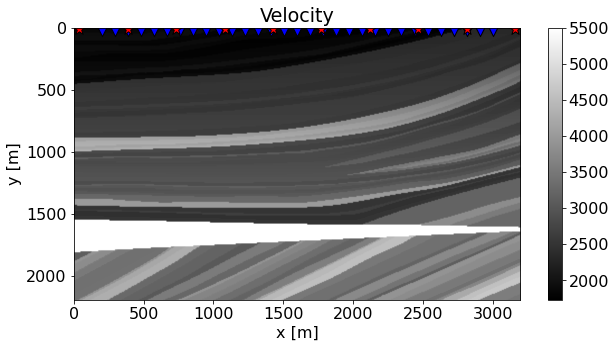

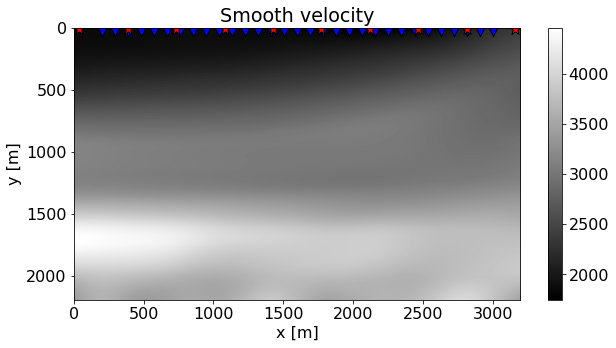

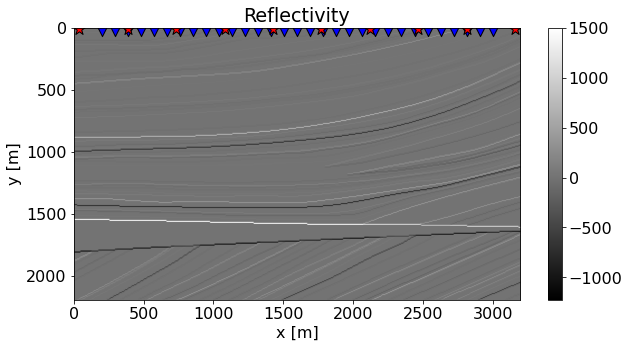

In [14]:
#Velocity
inputfile='../../pylops/testdata/avo/poststack_model.npz'

model = np.load(inputfile)
x, z, vel_true = model['x'] - model['x'][0], model['z'] - model['z'][0], 1000*model['model'].T
nx, nz = len(x), len(z)

# Reflectivity
refl = np.diff(vel_true, axis=1)
refl = np.hstack([refl, np.zeros((nx, 1))])

# Smooth velocity
nsmooth=100
vel = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, vel_true, axis=0)
vel = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, vel, axis=1)

# Receivers
nr = 31
rx = np.linspace(dx*50, (nx-50)*dx, nr)
rz = 20*np.ones(nr)
recs = np.vstack((rx, rz))
dr = recs[0,1]-recs[0,0]

# Sources
ns = 10
sx = np.linspace(dx*10, (nx-10)*dx, ns)
sz = 10*np.ones(ns)
sources = np.vstack((sx, sz))
ds = sources[0,1]-sources[0,0]

plt.figure(figsize=(10,5))
im = plt.imshow(vel_true.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Velocity')
plt.ylim(z[-1], z[0])

plt.figure(figsize=(10,5))
im = plt.imshow(vel.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Smooth velocity')
plt.ylim(z[-1], z[0])

plt.figure(figsize=(10,5))
im = plt.imshow(refl.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Reflectivity')
plt.ylim(z[-1], z[0]);

Compute traveltimes with eikonal

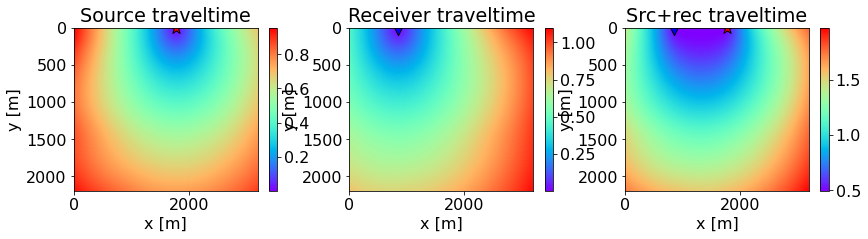

In [15]:
trav_srcs, trav_recs, dist_srcs, dist_recs, trav_srcs_grad, trav_recs_grad = \
    Kirchhoff._traveltime_table(z, x, sources, recs, vel, mode='eikonal')

trav = trav_srcs.reshape(nx * nz, ns, 1) + trav_recs.reshape(nx * nz, 1, nr)
trav = trav.reshape(nx * nz, ns * nr)

fig, axs = plt.subplots(1, 3, figsize=(14, 3))
im = axs[0].imshow(trav_srcs[:, ns//2].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[0].scatter(sources[0, ns//2], sources[1, ns//2], marker='*', s=150, c='r', edgecolors='k')
axs[0].axis('tight')
axs[0].set_xlabel('x [m]')
axs[0].set_ylabel('y [m]')
axs[0].set_title('Source traveltime')
axs[0].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(trav_recs[:, nr//4].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[1].scatter(recs[0, nr//4], recs[1, nr//4], marker='v', s=150, c='b', edgecolors='k')
axs[1].axis('tight')
axs[1].set_xlabel('x [m]')
axs[1].set_ylabel('y [m]')
axs[1].set_title('Receiver traveltime')
axs[1].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[1])
im = axs[2].imshow(trav[:, ns//2*nr+nr//4].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[2].scatter(sources[0, ns//2], sources[1, ns//2], marker='*', s=150, c='r', edgecolors='k')
axs[2].scatter(recs[0, nr//4], recs[1, nr//4], marker='v', s=150, c='b', edgecolors='k')
axs[2].axis('tight')
axs[2].set_xlabel('x [m]')
axs[2].set_ylabel('y [m]')
axs[2].set_title('Src+rec traveltime')
axs[2].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[2]);

Create data and invert model

In [16]:
nt = 751
dt = 0.004
t = np.arange(nt)*dt

lsm = LSM(z, x, t, sources, recs, vel, wav, wavc, mode='eikonal', engine='numba')
d = lsm.Demop * refl.ravel()
d = d.reshape(ns, nr, nt)

madj = lsm.Demop.H * d.ravel()
madj = madj.reshape(nx, nz)

minv = lsm.solve(d.ravel(), solver=lsqr, **dict(iter_lim=100, show=True))
minv = minv.reshape(nx, nz)

minv_sparse = lsm.solve(d.ravel(), solver=fista, **dict(eps=1e2, niter=100, show=True))
minv_sparse = minv_sparse.reshape(nx, nz)

# demigration
dadj = lsm.Demop * madj.ravel()
dadj = dadj.reshape(ns, nr, nt)

dinv = lsm.Demop * minv.ravel()
dinv = dinv.reshape(ns, nr, nt)

dinv_sparse = lsm.Demop * minv_sparse.ravel()
dinv_sparse = dinv_sparse.reshape(ns, nr, nt)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 232810 rows and 440000 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =      100
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   1.691e+07  1.691e+07    1.0e+00  4.1e-05
     1 -3.12608e+00   1.434e+07  1.434e+07    8.5e-01  5.3e-01   1.3e+03  1.0e+00
     2 -8.10160e+00   9.748e+06  9.748e+06    5.8e-01  3.2e-01   2.0e+03  3.1e+00
     3 -8.66536e+00   7.509e+06  7.509e+06    4.4e-01  2.5e-01   2.3e+03  4.7e+00
     4 -7.63638e+00   6.318e+06  6.318e+06    3.7e-01  1.8e-01   2.6e+03  6.3e+00
     5 -3.96887e+00   5.169e+06  5.169e+06    3.1e-01  1.7e-01   2.8e+03  8.3e+00
     6 -7.86070e-01   4.247e+06  4.247e+06    2.5e-01  1.3e-01   3.0e+03  1.0e+01
     7  5.05756e-01   3.579e+06  3.579e+06    2.1e-01  1.2e-01   3.2e+03  1.3e+01
     8  1.17155e+00   2.934e+0

(-0.5, 30.5, 499.5, -0.5)

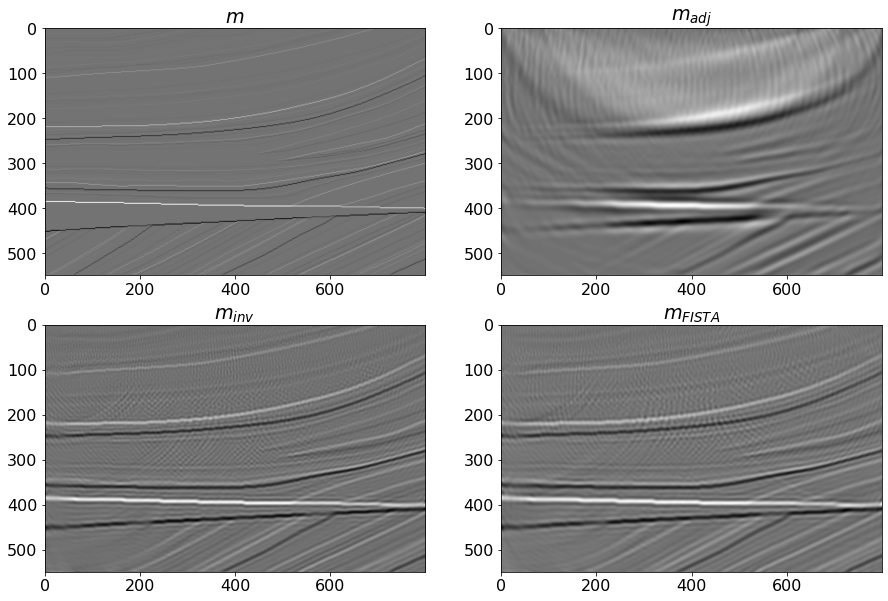

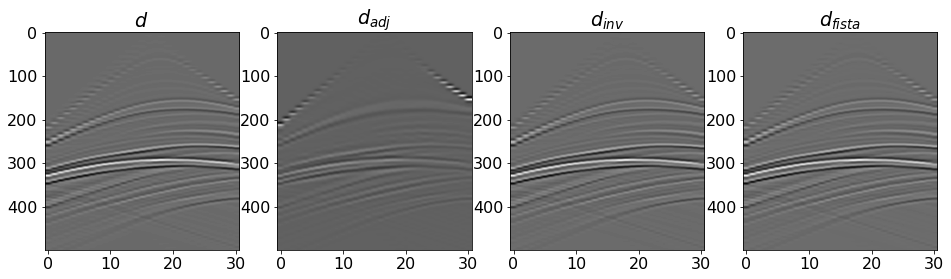

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0][0].imshow(refl.T, cmap='gray')
axs[0][0].axis('tight')
axs[0][0].set_title(r'$m$')
axs[0][1].imshow(madj.T, cmap='gray')
axs[0][1].set_title(r'$m_{adj}$')
axs[0][1].axis('tight')
axs[1][0].imshow(minv.T, cmap='gray')
axs[1][0].axis('tight')
axs[1][0].set_title(r'$m_{inv}$');
axs[1][1].imshow(minv_sparse.T, cmap='gray')
axs[1][1].axis('tight')
axs[1][1].set_title(r'$m_{FISTA}$');

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].imshow(d[ns//2, :, :500].T, cmap='gray')
axs[0].set_title(r'$d$')
axs[0].axis('tight')
axs[1].imshow(dadj[ns//2, :, :500].T, cmap='gray')
axs[1].set_title(r'$d_{adj}$')
axs[1].axis('tight')
axs[2].imshow(dinv[ns//2, :, :500].T, cmap='gray')
axs[2].set_title(r'$d_{inv}$')
axs[2].axis('tight');
axs[3].imshow(dinv_sparse[ns//2, :, :500].T, cmap='gray')
axs[3].set_title(r'$d_{fista}$')
axs[3].axis('tight');

Finally let's again invert for the model itself

In [18]:
trav_srcs, trav_recs, dist_srcs, dist_recs, trav_srcs_grad, trav_recs_grad = \
    Kirchhoff._traveltime_table(z, x, sources, recs, vel, mode='eikonal')

trav = trav_srcs.reshape(nx * nz, ns, 1) + trav_recs.reshape(nx * nz, 1, nr)
trav = trav.reshape(nx * nz, ns * nr)

itrav = (np.floor(trav/dt)).astype(np.int32)
travd = (trav/dt - itrav)
itrav = itrav.reshape(nx, nz, ns*nr)
travd = travd.reshape(nx, nz, ns*nr)

# Modelling
Sop = Spread(dims=(nx, nz), dimsd=(ns*nr, nt), table=itrav, dtable=travd, engine='numba')
dottest(Sop, ns*nr*nt, nx*nz, verb=True)

wav, wavt, wavc = ricker(t[:41], f0=20)
Cop = Convolve1D(dims=(ns*nr, nt), h=wav, offset=wavc, axis=1)
Dop = FirstDerivative(dims=(nx, nz), axis=1)
LSMop = Cop*Sop*Dop

d = LSMop * np.log(vel_true).ravel()
d = d.reshape(ns, nr, nt)
dback = LSMop * np.log(vel).ravel()
dback = dback.reshape(ns, nr, nt)

madj = (Cop*Sop).H * d.ravel()
madj = madj.reshape(nx, nz)

# Regularized inversion
Regop = SecondDerivative(dims=(nx, nz), axis=0)
minv = regularized_inversion(LSMop, d.ravel(), [Regop], 
                            x0=np.log(vel).ravel(),
                            epsRs=[1e1], **dict(iter_lim=200, show=True))[0]
minv = np.exp(minv.reshape((nx, nz)))

# demigration
dadj = (Cop*Sop) * madj.ravel()
dadj = dadj.reshape(ns, nr, nt)

dinv = LSMop *  np.log(minv).ravel()
dinv = dinv.reshape(ns, nr, nt)

Dot test passed, v^H(Opu)=-3611.5515373335247 - u^H(Op^Hv)=-3611.551537333564
RegularizedInversion
-----------------------------------------------------------------
The Operator Op has 232810 rows and 440000 cols
Regs=[<440000x440000 SecondDerivative with dtype=float64>]
epsRs=[10.0]
-----------------------------------------------------------------
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 672810 rows and 440000 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =      200
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   4.487e+03  4.487e+03    1.0e+00  1.9e-02
     1  5.03142e-02   2.589e+03  2.589e+03    5.8e-01  7.1e-01   1.0e+02  1.0e+00
     2  6.09726e-02   1.922e+03  1.922e+03    4.3e-01  5.2e-01   1.6e+02  2.2e+00
     3  7.06324e-02   1.471e+03  1.471e+03    3.3e-01  2.7e-01   2.3e+02  4.0e+00
     4 

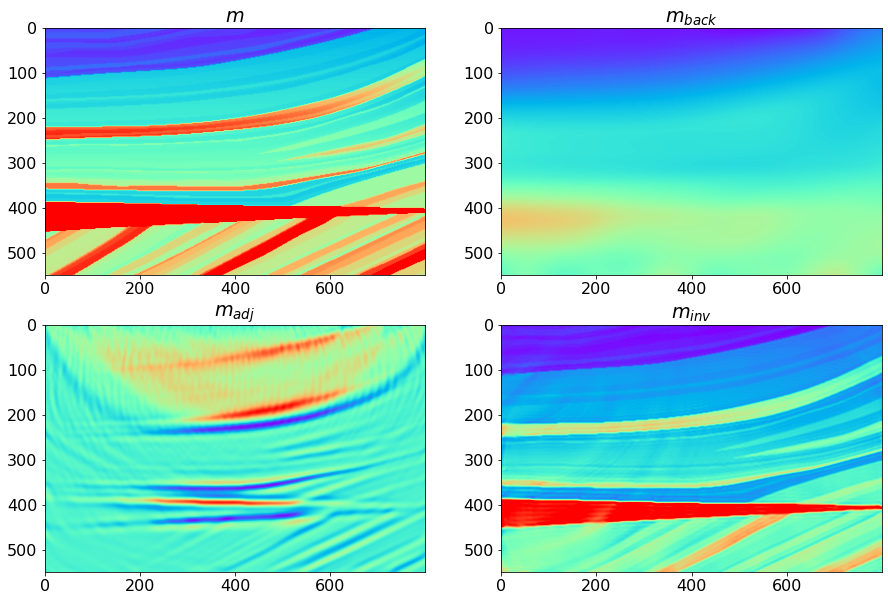

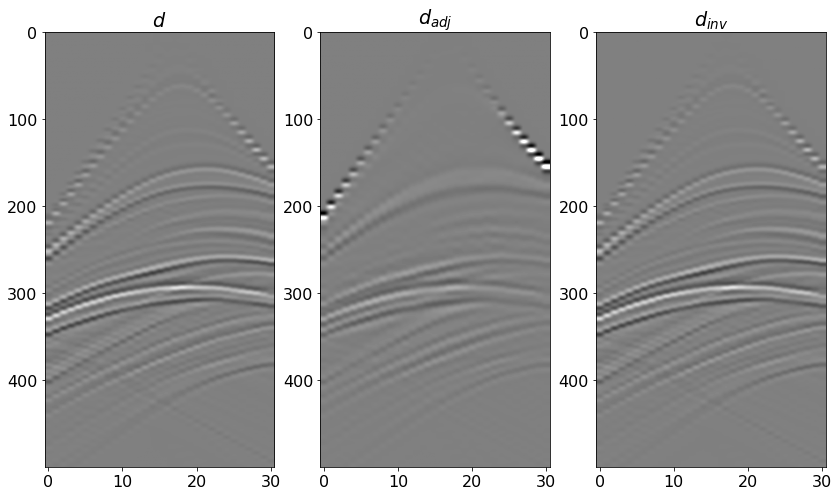

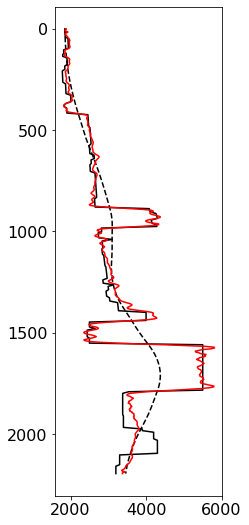

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0][0].imshow(vel_true.T, cmap='rainbow', vmin=v0, vmax=vel.max())
axs[0][0].axis('tight')
axs[0][0].set_title(r'$m$')
axs[0][1].imshow(vel.T, cmap='rainbow', vmin=vel_true.min(), vmax=vel_true.max())
axs[0][1].set_title(r'$m_{back}$')
axs[0][1].axis('tight')
axs[1][0].imshow(madj.T, cmap='rainbow')
axs[1][0].axis('tight')
axs[1][0].set_title(r'$m_{adj}$');
axs[1][1].imshow(minv.T, cmap='rainbow', vmin=vel_true.min(), vmax=vel_true.max())
axs[1][1].axis('tight')
axs[1][1].set_title(r'$m_{inv}$');

fig, axs = plt.subplots(1, 3, figsize=(14, 8))
axs[0].imshow(d[ns//2, :, :500].T, cmap='gray',
              vmin=-0.5*d.max(), vmax=0.5*d.max())
axs[0].set_title(r'$d$')
axs[0].axis('tight')
axs[1].imshow(dadj[ns//2, :, :500].T, cmap='gray',
              vmin=-0.1*dadj.max(), vmax=0.1*dadj.max())
axs[1].set_title(r'$d_{adj}$')
axs[1].axis('tight')
axs[2].imshow(dinv[ns//2, :, :500].T, cmap='gray',
              vmin=-0.5*d.max(), vmax=0.5*d.max())
axs[2].set_title(r'$d_{inv}$')
axs[2].axis('tight');

plt.figure(figsize=(3, 9))
plt.plot(vel_true[100], z, 'k')
plt.plot(vel[100], z, '--k')
plt.plot(minv[100], z, 'r')
plt.gca().invert_yaxis()

## 3D homogenous

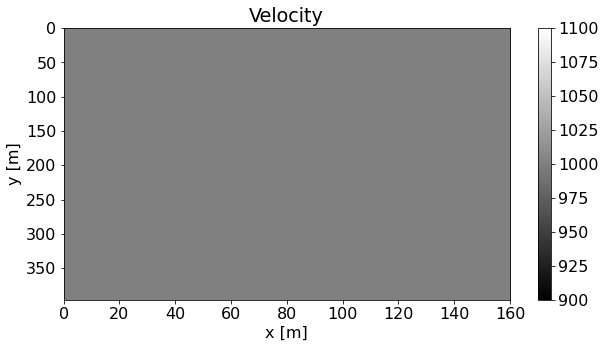

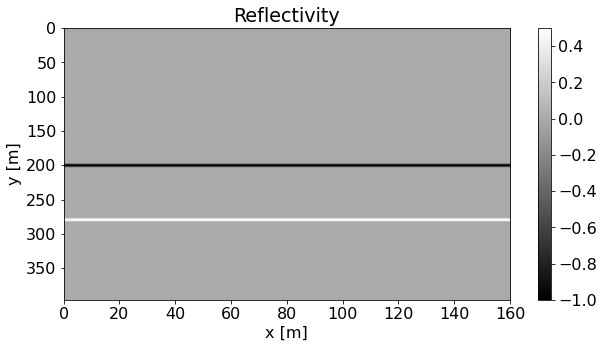

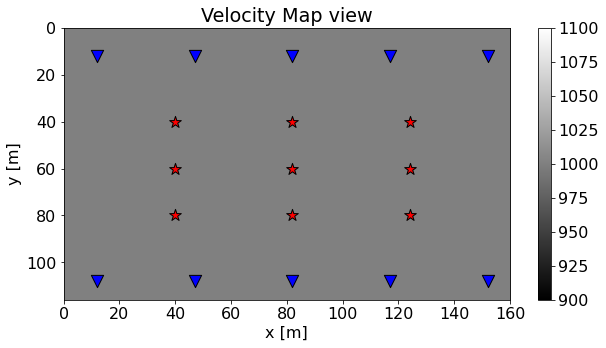

In [20]:
# Velocity Model
ny, nx, nz = 30, 41, 100
dy, dx, dz = 4, 4, 4
y, x, z = np.arange(ny)*dy, np.arange(nx)*dx, np.arange(nz)*dz
v0 = 1000 # initial velocity
vel = v0*np.ones((ny, nx, nz))

# Reflectivity Model
refl = np.zeros((ny, nx, nz))
refl[:, :, 50] = -1
refl[:, :,70] = 0.5

# Receivers
nry, nrx = 2, 5
nr = nry*nrx
ry = np.linspace(3*dy, (ny-3)*dy, nry)
rx = np.linspace(3*dx, (nx-3)*dx, nrx)
ry, rx = np.meshgrid(ry, rx, indexing='ij')
ry, rx = ry.flatten(), rx.flatten()
rz = 20*np.ones(nry*nrx)
recs = np.vstack((ry, rx, rz))
dry = recs[0,1]-recs[0,0]
drx = recs[1,1]-recs[1,0]

# Sources
nsy, nsx = 3, 3
ns = nsy*nsx
sy = np.linspace(10*dy, (ny-10)*dy, nsy)
sx = np.linspace(10*dx, (nx-10)*dx, nsx)
sy, sx = np.meshgrid(sy, sx, indexing='ij')
sy, sx = sy.flatten(), sx.flatten()
sz = 20*np.ones(nsy*nsx)
sources = np.vstack((sy, sx, sz))
dsy = sources[0,1]-sources[0,0]
dsx = sources[1,1]-sources[1,0]

plt.figure(figsize=(10,5))
im = plt.imshow(vel[ny//2].T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Velocity')
plt.xlim(x[0], x[-1])

plt.figure(figsize=(10,5))
im = plt.imshow(refl[ny//2].T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Reflectivity')
plt.xlim(x[0], x[-1]);

plt.figure(figsize=(10,5))
im = plt.imshow(vel[:, :, nz//2], cmap='gray', extent = (x[0], x[-1], y[-1], y[0]))
plt.scatter(recs[1],  recs[0], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[1], sources[0], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Velocity Map view')
plt.xlim(x[0], x[-1]);

In [21]:
nt = 651
dt = 0.004
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:41], f0=20)

lsm = LSM(z, x, t, sources, recs, v0, wav, wavc, y=y, mode='analytic', engine='numba')

d = lsm.Demop * refl.ravel()
d = d.reshape(ns, nr, nt)

madj = lsm.Demop.H * d.ravel()
madj = madj.reshape(ny, nx, nz)

minv = lsm.solve(d.ravel(), solver=lsqr, **dict(iter_lim=100, show=True))
minv = minv.reshape(ny, nx, nz)

minv_sparse = lsm.solve(d.ravel(), solver=fista, **dict(eps=1e-2, niter=200, show=True))
minv_sparse = minv_sparse.reshape(ny, nx, nz)

# demigration
dadj = lsm.Demop * madj.ravel()
dadj = dadj.reshape(ns, nr, nt)

dinv = lsm.Demop * minv.ravel()
dinv = dinv.reshape(ns, nr, nt)

dinv_sparse = lsm.Demop * minv_sparse.ravel()
dinv_sparse = dinv_sparse.reshape(ns, nr, nt)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 58590 rows and 123000 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =      100
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   7.810e+03  7.810e+03    1.0e+00  5.7e-02
     1 -5.89041e-04   4.077e+03  4.077e+03    5.2e-01  7.0e-01   5.2e+02  1.0e+00
     2 -1.03547e-03   2.736e+03  2.736e+03    3.5e-01  3.5e-01   7.6e+02  2.2e+00
     3 -1.02708e-03   2.127e+03  2.127e+03    2.7e-01  3.0e-01   9.0e+02  3.6e+00
     4 -2.26823e-04   1.727e+03  1.727e+03    2.2e-01  2.2e-01   1.1e+03  5.2e+00
     5  2.07983e-03   1.407e+03  1.407e+03    1.8e-01  2.3e-01   1.2e+03  7.1e+00
     6  5.15200e-03   1.148e+03  1.148e+03    1.5e-01  1.5e-01   1.3e+03  9.2e+00
     7  8.76959e-03   9.892e+02  9.892e+02    1.3e-01  1.3e-01   1.4e+03  1.1e+01
     8  1.28839e-02   8.446e+02

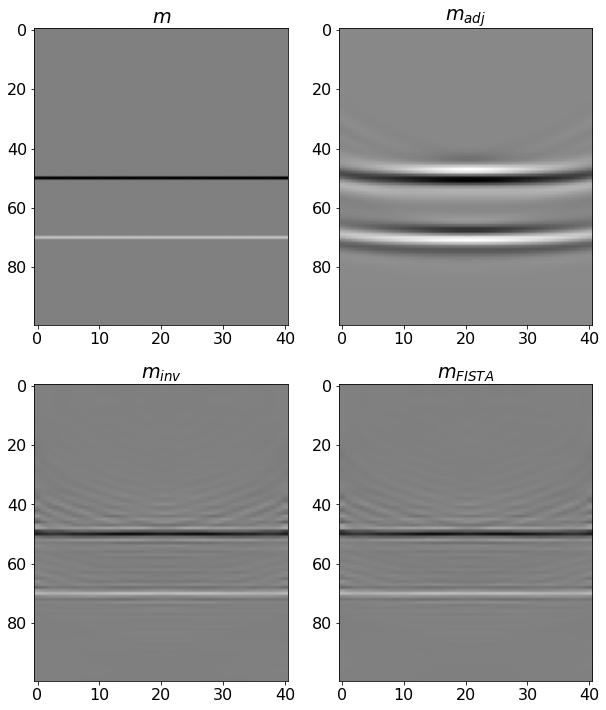

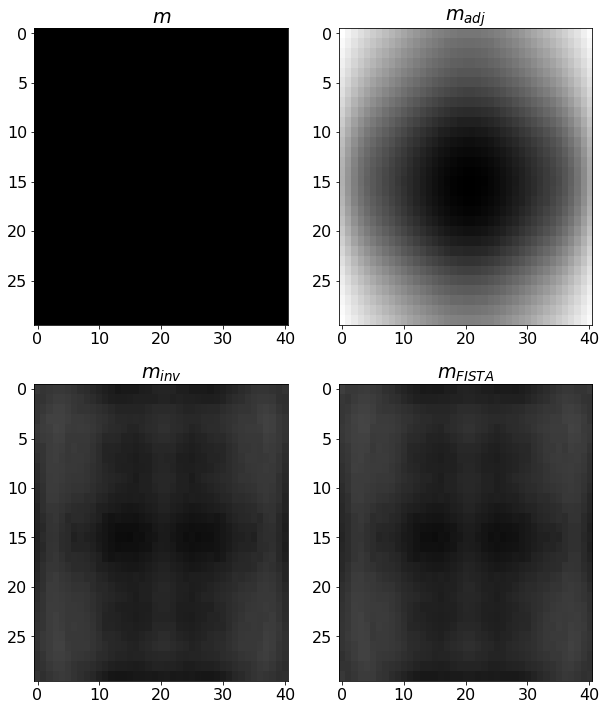

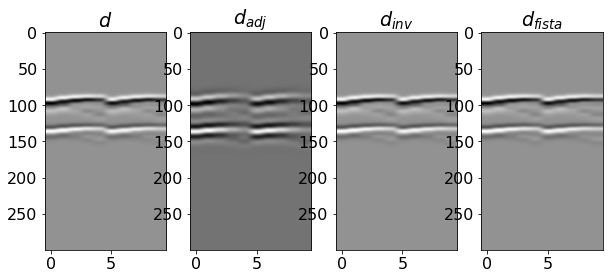

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(10, 12))
axs[0][0].imshow(refl[ny//2].T, cmap='gray', vmin=-1, vmax=1)
axs[0][0].axis('tight')
axs[0][0].set_title(r'$m$')
axs[0][1].imshow(madj[ny//2].T, cmap='gray')
axs[0][1].set_title(r'$m_{adj}$')
axs[0][1].axis('tight')
axs[1][0].imshow(minv[ny//2].T, cmap='gray', vmin=-1, vmax=1)
axs[1][0].axis('tight')
axs[1][0].set_title(r'$m_{inv}$');
axs[1][1].imshow(minv_sparse[ny//2].T, cmap='gray', vmin=-1, vmax=1)
axs[1][1].axis('tight')
axs[1][1].set_title(r'$m_{FISTA}$');

fig, axs = plt.subplots(2, 2, figsize=(10, 12))
axs[0][0].imshow(refl[...,50], cmap='gray', vmin=-1, vmax=1)
axs[0][0].axis('tight')
axs[0][0].set_title(r'$m$')
axs[0][1].imshow(madj[...,50], cmap='gray')
axs[0][1].set_title(r'$m_{adj}$')
axs[0][1].axis('tight')
axs[1][0].imshow(minv[...,50], cmap='gray', vmin=-1, vmax=1)
axs[1][0].axis('tight')
axs[1][0].set_title(r'$m_{inv}$');
axs[1][1].imshow(minv_sparse[...,50], cmap='gray', vmin=-1, vmax=1)
axs[1][1].axis('tight')
axs[1][1].set_title(r'$m_{FISTA}$');

fig, axs = plt.subplots(1, 4, figsize=(10, 4))
axs[0].imshow(d[ns//2 + nsx//2, :, :300].T, cmap='gray')
axs[0].set_title(r'$d$')
axs[0].axis('tight')
axs[1].imshow(dadj[ns//2+ nsx//2, :, :300].T, cmap='gray')
axs[1].set_title(r'$d_{adj}$')
axs[1].axis('tight')
axs[2].imshow(dinv[ns//2+ nsx//2, :, :300].T, cmap='gray')
axs[2].set_title(r'$d_{inv}$')
axs[2].axis('tight')
axs[3].imshow(dinv_sparse[ns//2+ nsx//2, :, :300].T, cmap='gray')
axs[3].set_title(r'$d_{fista}$')
axs[3].axis('tight');

So far so good but there is much more here to explore:

- First of all we all know that waves do not propagate vertically, so the derivative operator from medium properties to reflectivity should be done normal to the propagation. We could track propagation angles using the wavefront of the traveltime map and use that also to reduce the pairs of sources and receivers to only ones that verify the Snell's law. 

- Along these lines, we could couple localized AVO modelling with the ray-based demigration process and estimate elastic properties even if using only P-waves for the modelling.